In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn, optim
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image 
from IPython.display import display
import matplotlib.pyplot as plt
import pickle

## Check BBox Size

In [5]:
file = open('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/bbox.pkl','rb')
bbox_list = pickle.load(file)

In [6]:
large_dx, large_dy = 0, 0
small_dx, small_dy = 16, 16

for index in range(0, len(bbox_list)):
  for i in range(0, len(bbox_list[index])):
    if bbox_list[index][i][2] - bbox_list[index][i][0] > large_dx:
      large_dx = bbox_list[index][i][2] - bbox_list[index][i][0]
    
    if bbox_list[index][i][3] - bbox_list[index][i][1] > large_dy:
      large_dy = bbox_list[index][i][3] - bbox_list[index][i][1]
    
    if bbox_list[index][i][2] - bbox_list[index][i][0] < small_dx and bbox_list[index][i][2] - bbox_list[index][i][0] != 0:
      small_dx = bbox_list[index][i][2] - bbox_list[index][i][0]
      # print("############################")
      # print(index)
      # print(bbox_list[index][i])
      # print("dx is small: " + str(bbox_list[index][i][2] - bbox_list[index][i][0]))
      # print("dy is " + str(bbox_list[index][i][3] - bbox_list[index][i][1]))
    
    if bbox_list[index][i][3] - bbox_list[index][i][1] < small_dy and bbox_list[index][i][3] - bbox_list[index][i][1] != 0:
      small_dy = bbox_list[index][i][3] - bbox_list[index][i][1]
      # print("############################")
      # print(index)
      # print(bbox_list[index][i])
      # print("dy is small: " + str(bbox_list[index][i][3] - bbox_list[index][i][1]))
      # print("dx is " + str(bbox_list[index][i][2] - bbox_list[index][i][0]))

print(large_dx, large_dy, small_dx, small_dy) 

51 45 3 4


# Make Data

## Settings

In [7]:
crop = False #需要經過RCNN / 一條龍
padding = False #額外包含邊界資訊 / 原始

###################################
# 一條龍就不需要bounding box  #
# 一條龍才會有clean data    #
###################################

# 防呆
padding = padding and crop

## Read in Data

In [8]:
meta = pd.read_csv('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/Meta/meta_info.csv')

# test 1-30 valid 31-40 test 41-50
train_img, train_mask, train_bbox = [], [], []
valid_img, valid_mask, valid_bbox = [], [], []
test_img, test_mask, test_bbox = [], [], []
test_display_index = []
tdi = 0

file = open('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/bbox.pkl','rb')
bbox_list = pickle.load(file)

# check for abnormal bounding box
abnormal_index = []
for index in range(0, len(bbox_list)):
 if len(bbox_list[index]) != 1:
  for target_index in range(0, len(bbox_list[index])):
    for check_index in range(0, len(bbox_list[index])):
      if target_index == check_index:
        continue
      else:
        t = bbox_list[index][target_index]
        c = bbox_list[index][check_index]
        if t[0] >= c[0] and t[0] <= c[2] and t[1] >= c[1] and t[1] <= c[3]:
          print('abnormal at index ' + str(index))
          abnormal_index.append(index)
          print(bbox_list[index])
        elif t[2] >= c[0] and t[2] <= c[2] and t[3] >= c[1] and t[3] <= c[3]:
          print('abnormal at index ' + str(index))
          abnormal_index.append(index)
          print(bbox_list[index])

# padding to include more information
if padding == True:
  for index in range(0, len(bbox_list)):
    if index in abnormal_index:
      continue

    if len(bbox_list[index]) == 1:
      if bbox_list[index][0][2] - bbox_list[index][0][0] <= 16 and bbox_list[index][0][3] - bbox_list[index][0][1] <= 16:
        x_pad = 32 - (bbox_list[index][0][2] - bbox_list[index][0][0]) + 1
        y_pad = 32 - (bbox_list[index][0][3] - bbox_list[index][0][1]) + 1
      elif bbox_list[index][0][2] - bbox_list[index][0][0] <= 32 and bbox_list[index][0][3] - bbox_list[index][0][1] <= 32:
        x_pad = 48 - (bbox_list[index][0][2] - bbox_list[index][0][0]) + 1
        y_pad = 48 - (bbox_list[index][0][3] - bbox_list[index][0][1]) + 1
      else:
        x_pad = 64 - (bbox_list[index][0][2] - bbox_list[index][0][0]) + 1
        y_pad = 64 - (bbox_list[index][0][3] - bbox_list[index][0][1]) + 1
      bbox_list[index][0][0] = bbox_list[index][0][0] - int(x_pad/2)
      bbox_list[index][0][2] = bbox_list[index][0][2] + int(x_pad/2)
      if x_pad % 2 == 1:
        if bbox_list[index][0][0] > 1:
          bbox_list[index][0][0] -= 1
        else:
          bbox_list[index][0][2] += 1
      bbox_list[index][0][1] = bbox_list[index][0][1] - int(y_pad/2)
      bbox_list[index][0][3] = bbox_list[index][0][3] + int(y_pad/2)
      if y_pad % 2 == 1:
        if bbox_list[index][0][1] > 1:
          bbox_list[index][0][1] -= 1
        else:
          bbox_list[index][0][3] += 1
    else:
      new_bboxs = []
      for target_index in range(0, len(bbox_list[index])):
        t = bbox_list[index][target_index]

        # 先計算完一般來說要padding的大小
        if t[2] - t[0] <= 16 and t[3] - t[1] <= 16:
          x_pad = 32 - (t[2] - t[0])
          y_pad = 32 - (t[3] - t[1])
        elif t[2] - t[0] <= 32 and t[3] - t[1] <= 32:
          x_pad = 48 - (t[2] - t[0])
          y_pad = 48 - (t[3] - t[1])
        else:
          x_pad = 64 - (t[2] - t[0])
          y_pad = 64 - (t[3] - t[1])
        
        
        x1 = t[0] - int(x_pad/2)
        x2 = t[2] + int(x_pad/2)
        if x_pad % 2 == 1:
          if x1 > 1:
            x1 -= 1
          else:
            x2 += 1
        y1 = t[1] - int(y_pad/2)
        y2 = t[3] + int(y_pad/2)
        if y_pad % 2 == 1:
          if y1 > 1:
            y1 -= 1
          else:
            y2 += 1

        # 再檢查這樣會不會pad到別人家
        for check_index in range(0, len(bbox_list[index])):
          if target_index == check_index:
            continue

          c = bbox_list[index][check_index]
          if x1 > c[0] and x1 < c[2] and y1 > c[1] and y1 < c[3]:
            print('padding warning')
            x1, y1 = c[2], c[3] 
          elif x2 > c[0] and x2 < c[2] and y2 > c[1] and y2 < c[3]:
            print('padding warning')
            x2, y2 = c[0], c[1]
        
        new_bboxs.append([x1, y1, x2, y2])
      bbox_list[index] = new_bboxs

# load data
for i in tqdm(range(len(meta.index))):
  # 手動排除
  if i in abnormal_index:
    continue
  
  # load image
  if meta.iloc[i]['is_clean'] == False:
    img = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/Image/LIDC-IDRI-' + meta.iloc[i]['original_image'][:4] + '/' + meta.iloc[i]['original_image'] + '.npy')
  elif meta.iloc[i]['is_clean'] == True and crop == False:
    img = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/Clean/Image/LIDC-IDRI-' + meta.iloc[i]['original_image'][:4] + '/' + meta.iloc[i]['original_image'] + '.npy')
  img = np.clip(img, -1200, 1200)

  if img.shape[0] != 512 or img.shape[1] != 512:
    print(img.shape, meta.iloc[i]['patient_id'])
  
  # load mask
  if meta.iloc[i]['is_clean'] == False:
    mask = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_v2/Mask/LIDC-IDRI-' + meta.iloc[i]['mask_image'][:4] + '/' + meta.iloc[i]['mask_image'] + '.npy')
  elif meta.iloc[i]['is_clean'] == True and crop == False:
    mask = np.zeros((512, 512))

  # appending data
  if meta.iloc[i]['patient_id'] <= 30: 
    if crop == True and meta.iloc[i]['is_clean'] == False:
      for index in range(0, len(bbox_list[i])):
        train_img.append(img)
        train_mask.append(mask)
        train_bbox.append(bbox_list[i][index])
    elif crop == False:
      train_img.append(img)
      train_mask.append(mask)
  elif meta.iloc[i]['patient_id'] <= 40: 
    if crop == True and meta.iloc[i]['is_clean'] == False:
      for index in range(0, len(bbox_list[i])):
        valid_img.append(img)
        valid_mask.append(mask)
        valid_bbox.append(bbox_list[i][index])
    elif crop == False:
      valid_img.append(img)
      valid_mask.append(mask)
  else: 
    if crop == True and meta.iloc[i]['is_clean'] == False:
      test_display_index.append(tdi)
      for index in range(0, len(bbox_list[i])):
        test_img.append(img)
        test_mask.append(mask)
        test_bbox.append(bbox_list[i][index])
        tdi += 1
    elif crop == False:
      test_display_index.append(tdi)
      tdi += 1
      test_img.append(img)
      test_mask.append(mask)

abnormal at index 247
[[305, 262, 331, 296], [311, 262, 316, 267]]


100%|██████████| 1105/1105 [09:32<00:00,  1.93it/s]


## Crop Image

In [9]:
def crop_array(ary, x1, y1, x2, y2):
  rst = []
  for y in range(y1, y2+1):
    tmp = ary[y][x1: x2+1]
    rst.append(tmp)
  rst = np.array(rst)
  return rst

def switch_gv(ary):
  rst = []
  for index in range(0, ary.shape[0]):
    rst.append((ary[index] + 1200) / 9.375)
  rst = np.array(rst)
  return rst

def switch_1200(ary):
  rst = []
  for index in range(0, ary.shape[0]):
    rst.append((ary[index] * 9.375) - 1200)
  rst = np.array(rst)
  return rst

def img_with_mask(img, mask):
  rst = []
  for y in range(0, img.shape[0]):
    tmp = []
    for x in range(0, img.shape[1]):
      if mask[y][x] == True:
        tmp.append(1200)
      else:
        tmp.append(img[y][x])
    rst.append(tmp)
  rst = np.array(rst)
  return rst
  

In [10]:
crop_train_img, crop_train_mask = [], []
crop_valid_img, crop_valid_mask = [], []
crop_test_img, crop_test_mask = [], []

if crop == True:
  for index in range(0, len(train_bbox)):
    crop_train_img.append(crop_array(train_img[index], train_bbox[index][0], train_bbox[index][1], train_bbox[index][2], train_bbox[index][3]))
    crop_train_mask.append(crop_array(train_mask[index], train_bbox[index][0], train_bbox[index][1], train_bbox[index][2], train_bbox[index][3]))

  for index in range(0, len(valid_bbox)):
    crop_valid_img.append(crop_array(valid_img[index], valid_bbox[index][0], valid_bbox[index][1], valid_bbox[index][2], valid_bbox[index][3]))
    crop_valid_mask.append(crop_array(valid_mask[index], valid_bbox[index][0], valid_bbox[index][1], valid_bbox[index][2], valid_bbox[index][3]))

  for index in range(0, len(test_bbox)):
    crop_test_img.append(crop_array(test_img[index], test_bbox[index][0], test_bbox[index][1], test_bbox[index][2], test_bbox[index][3]))
    crop_test_mask.append(crop_array(test_mask[index], test_bbox[index][0], test_bbox[index][1], test_bbox[index][2], test_bbox[index][3]))
else:
  crop_train_img, crop_train_mask = train_img, train_mask
  crop_valid_img, crop_valid_mask = valid_img, valid_mask
  crop_test_img, crop_test_mask = test_img, test_mask

In [11]:
print(len(crop_train_img), len(crop_valid_img), len(crop_test_img))
print(type(crop_train_img))

678 174 252
<class 'list'>


## Demo(隨便挑幾張出來看看)

In [12]:
max_size, max_index = 0, 0
min_size, min_index = 400, 0
for index in range(0, len(crop_train_img)):
  if crop_train_img[index].size > max_size:
    max_size = crop_train_img[index].size
    max_index = index
  elif crop_train_img[index].size < min_size:
    min_size = crop_train_img[index].size
    min_index = index
print("The largest bbox size is " + str(max_size) + " . The index is " + str(max_index) + " .")
print("The smallest bbox size is " + str(min_size) + " . The index is " + str(min_index) + " .")

The largest bbox size is 262144 . The index is 0 .
The smallest bbox size is 400 . The index is 0 .


### index 0

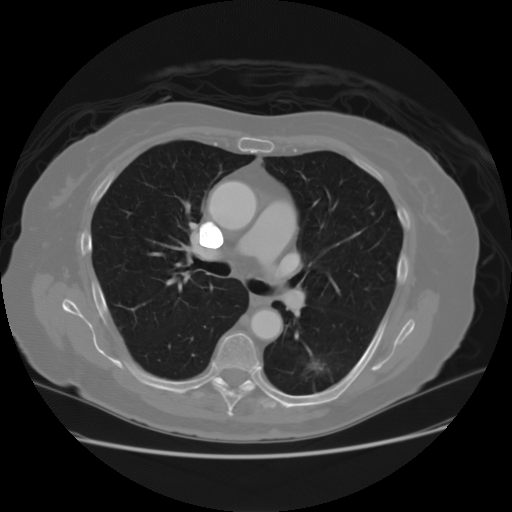

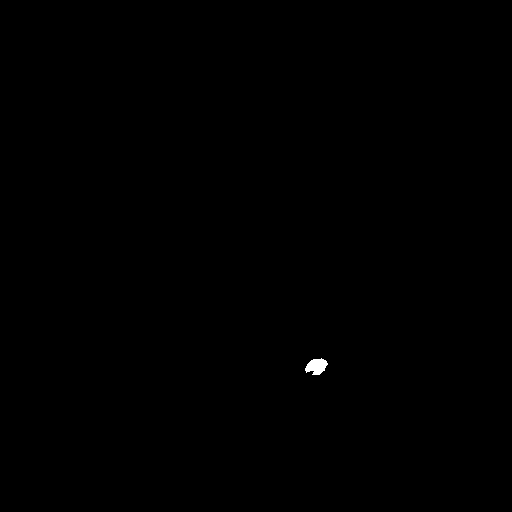

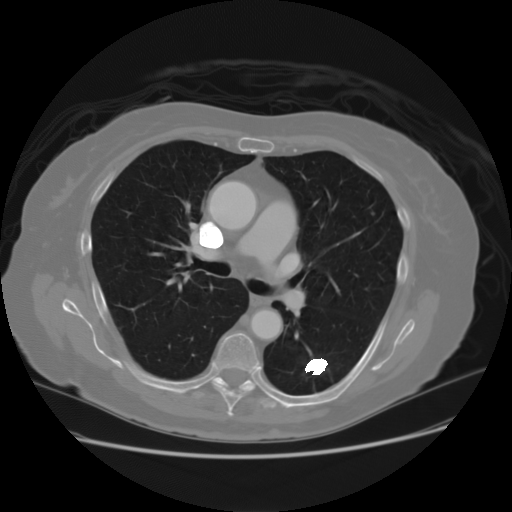

In [13]:
index = 0
img = switch_gv(train_img[index])
img_mask = img_with_mask(train_img[index], train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

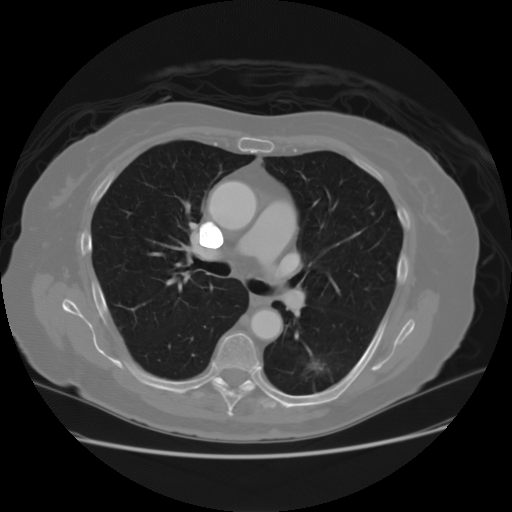

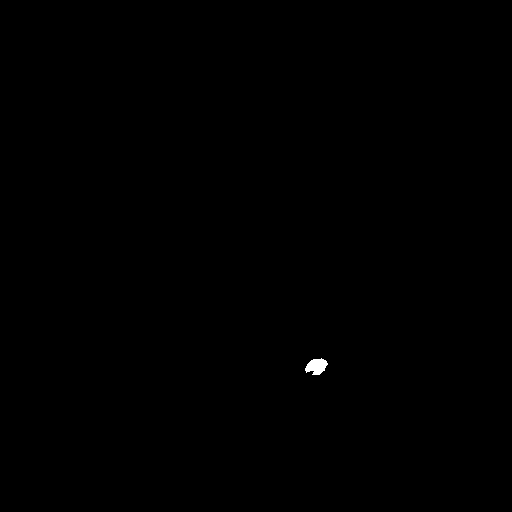

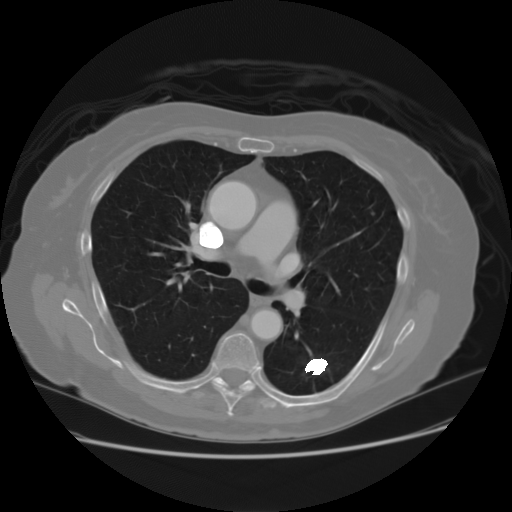

In [14]:
img = switch_gv(crop_train_img[index])
img_mask = img_with_mask(crop_train_img[index], crop_train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(crop_train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

### index 284(最大)

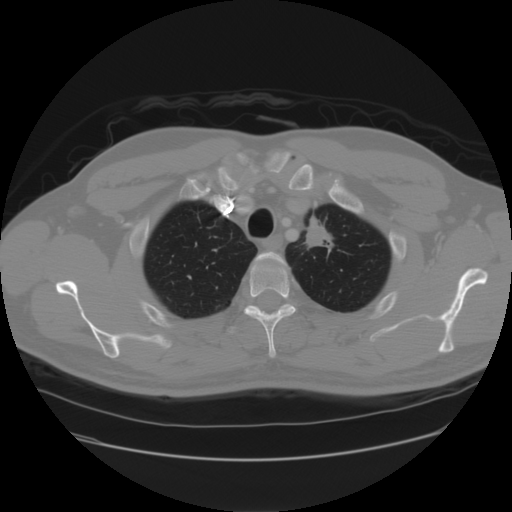

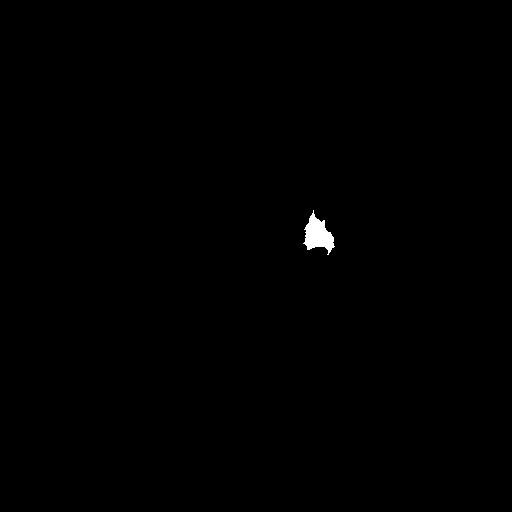

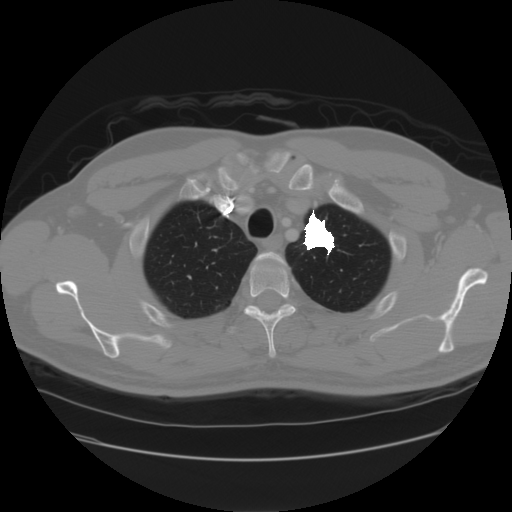

In [15]:
index = 284
img = switch_gv(train_img[index])
img_mask = img_with_mask(train_img[index], train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

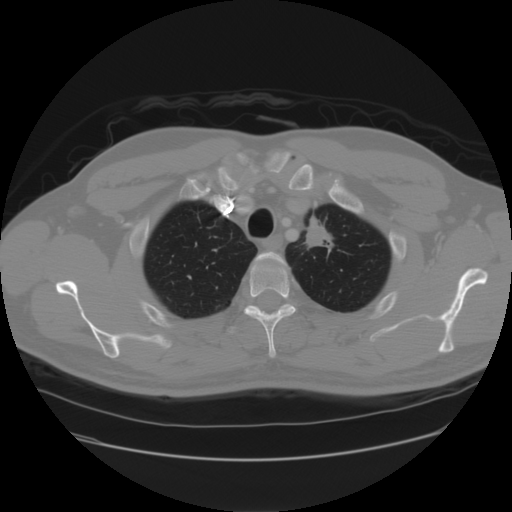

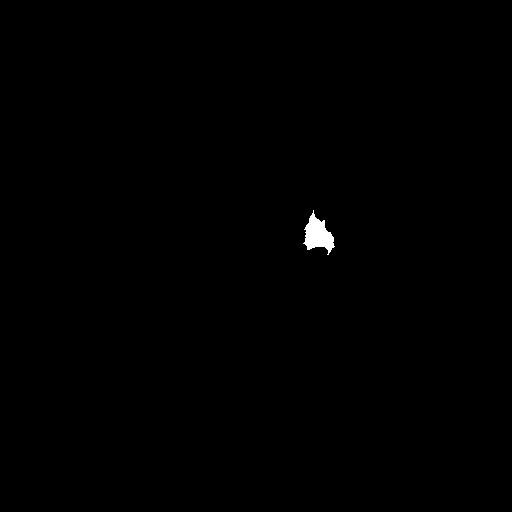

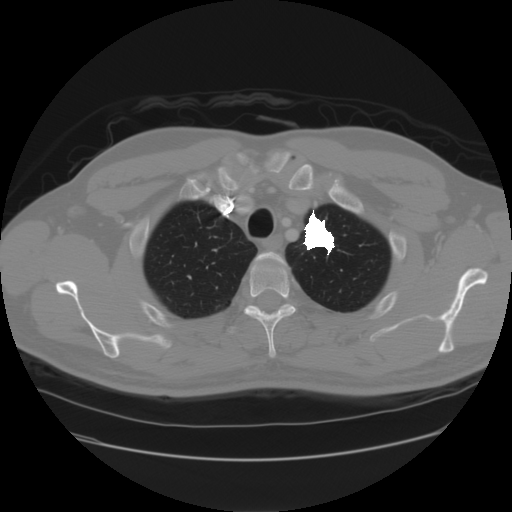

In [16]:
img = switch_gv(crop_train_img[index])
img_mask = img_with_mask(crop_train_img[index], crop_train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(crop_train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

### index 152(最小)

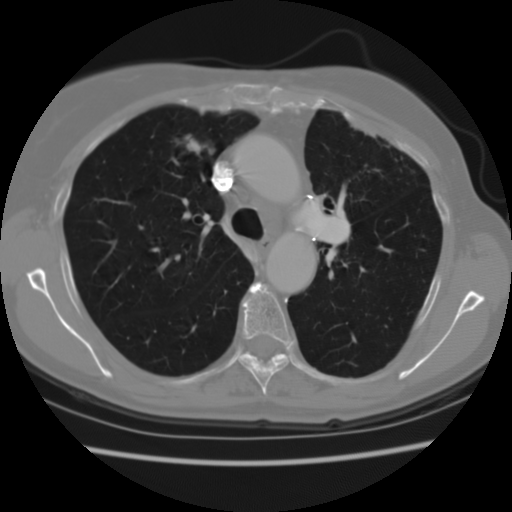

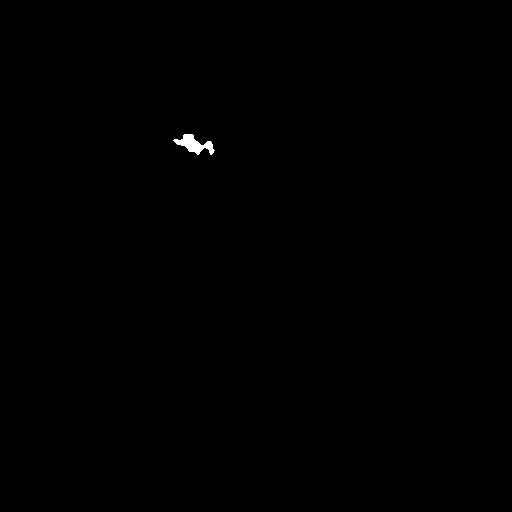

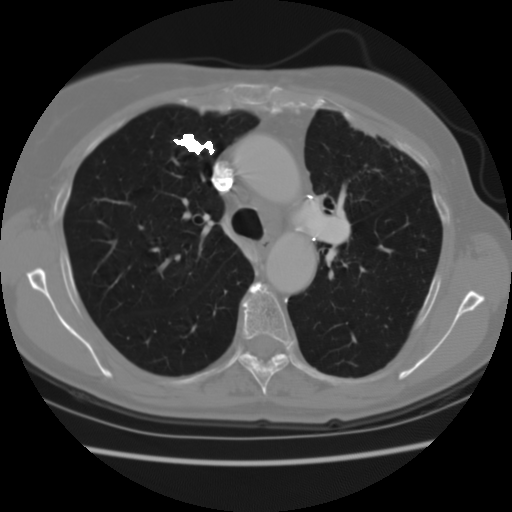

In [17]:
index = 152
img = switch_gv(train_img[index])
img_mask = img_with_mask(train_img[index], train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

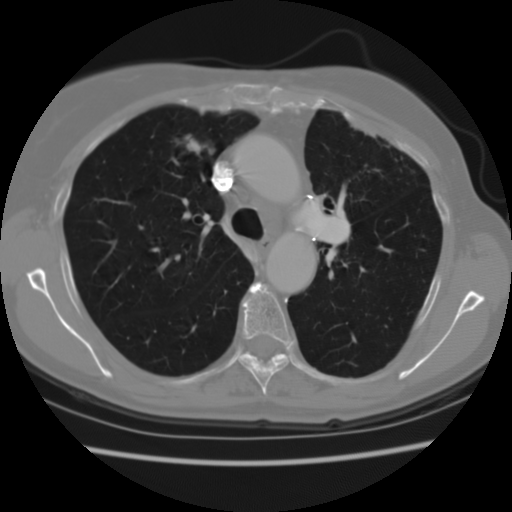

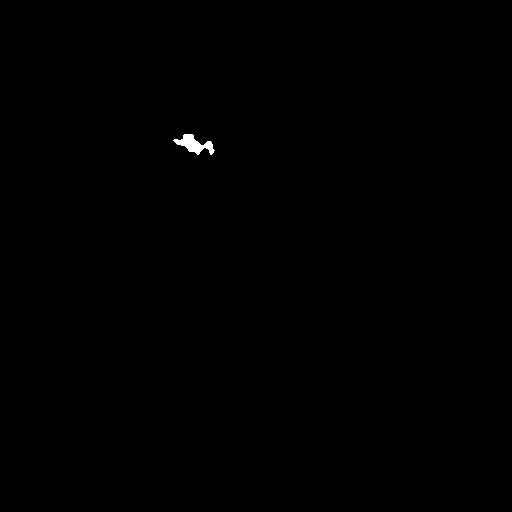

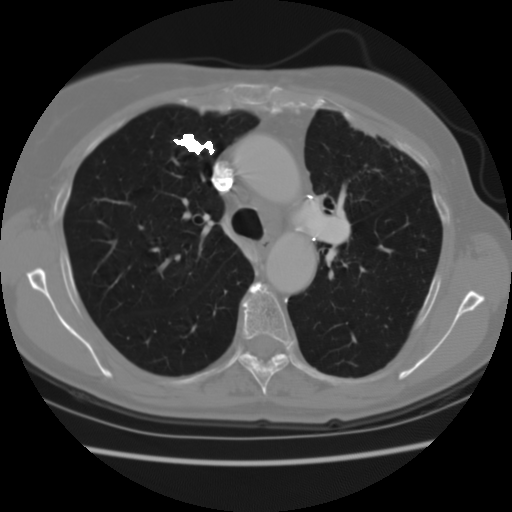

In [18]:
img = switch_gv(crop_train_img[index])
img_mask = img_with_mask(crop_train_img[index], crop_train_mask[index])
img_mask = switch_gv(img_mask)

img = Image.fromarray(img)
mask = Image.fromarray(crop_train_mask[index])
img_mask = Image.fromarray(img_mask)

img.show()
mask.show() 
img_mask.show()

## Resize成model要吃的大小

In [19]:
def resize_img(img, size_x, size_y):
  imgsize = (size_x, size_y)
  img = switch_gv(img)
  img = Image.fromarray(img)
  img = img.resize(imgsize)
  img = np.array(img)
  img = switch_1200(img)
  return img

def resize_mask(mask, size_x, size_y):
  masksize = (size_x, size_y)
  mask = Image.fromarray(mask)
  mask = mask.resize(masksize, resample = Image.NEAREST)
  mask = np.array(mask)
  mask = (mask==True).astype(int).astype(float)
  return mask

In [20]:
if crop == True:
  size = 64
else:
  size = 256

resize_train_img, resize_train_mask = [], []
resize_valid_img, resize_valid_mask = [], []
resize_test_img, resize_test_mask = [], []
for index in range(0, len(crop_train_img)):
  resize_train_img.append(resize_img(crop_train_img[index], size, size))
  resize_train_mask.append(resize_mask(crop_train_mask[index], size, size))
for index in range(0, len(crop_valid_img)):
  resize_valid_img.append(resize_img(crop_valid_img[index], size, size))
  resize_valid_mask.append(resize_mask(crop_valid_mask[index], size, size))
for index in range(0, len(crop_test_img)):
  resize_test_img.append(resize_img(crop_test_img[index], size, size))
  resize_test_mask.append(resize_mask(crop_test_mask[index], size, size))

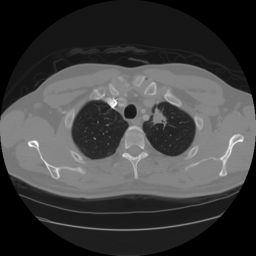

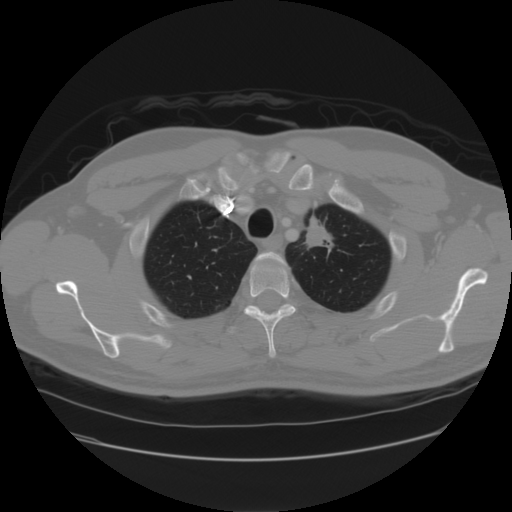

In [21]:
img = switch_gv(resize_train_img[284])
img = Image.fromarray(img)
img.show()
img = switch_gv(crop_train_img[284])
img = Image.fromarray(img)
img.show()

In [22]:
print(len(resize_train_img), len(resize_valid_img), len(resize_test_img))
print(resize_train_img[0].shape)

678 174 252
(256, 256)


In [23]:
mask = crop_train_mask[0]
masksize = (64, 64)
mask = Image.fromarray(mask)
mask = mask.resize(masksize, resample = Image.NEAREST)
mask = np.array(mask)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Model

## UNet

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out

## Dataset

In [25]:
class MyDataset(Dataset):
    def __init__(self, imgs, masks, transform=None, target_transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_x, img_y = self.imgs[index], self.masks[index]
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [26]:
# 是否使用cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# mask只需要转换为tensor
y_transforms = transforms.ToTensor()

## Train

In [28]:
model = Unet(1, 1).to(device)
batch_size = 8
num_epochs = 20
lr = 0.001
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.5)
dataset = MyDataset(resize_train_img, resize_train_mask, transform=x_transforms, target_transform=y_transforms)
dataloaders = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [29]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  epoch_loss = 0
  step = 0
  for x, y in dataloaders:
    step += 1
    inputs = x.float().to(device)
    labels = y.float().to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
if crop == False:
  torch.save(model.state_dict(), 'drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_no_crop.pth')
elif padding == False:
  torch.save(model.state_dict(), 'drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_no_pad.pth')
else:
  torch.save(model.state_dict(), 'drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_with_pad.pth')

Epoch 0/19
----------
epoch 0 loss:0.220
Epoch 1/19
----------
epoch 1 loss:0.055
Epoch 2/19
----------
epoch 2 loss:0.024
Epoch 3/19
----------
epoch 3 loss:0.014
Epoch 4/19
----------
epoch 4 loss:0.009
Epoch 5/19
----------
epoch 5 loss:0.007
Epoch 6/19
----------
epoch 6 loss:0.005
Epoch 7/19
----------
epoch 7 loss:0.004
Epoch 8/19
----------
epoch 8 loss:0.003
Epoch 9/19
----------
epoch 9 loss:0.003
Epoch 10/19
----------
epoch 10 loss:0.002
Epoch 11/19
----------
epoch 11 loss:0.002
Epoch 12/19
----------
epoch 12 loss:0.002
Epoch 13/19
----------
epoch 13 loss:0.002
Epoch 14/19
----------
epoch 14 loss:0.002
Epoch 15/19
----------
epoch 15 loss:0.001
Epoch 16/19
----------
epoch 16 loss:0.001
Epoch 17/19
----------
epoch 17 loss:0.001
Epoch 18/19
----------
epoch 18 loss:0.001
Epoch 19/19
----------
epoch 19 loss:0.001


## Test

In [30]:
if crop == False:
  model.load_state_dict(torch.load('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_no_crop.pth'))
elif padding == False:
  model.load_state_dict(torch.load('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_no_pad.pth'))
else:
  model.load_state_dict(torch.load('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_with_pad.pth'))

model = model.to(device)
dataset = MyDataset(resize_test_img, resize_test_mask, transform=x_transforms, target_transform=y_transforms)
dataloaders = DataLoader(dataset, batch_size=batch_size, shuffle=False)
model.eval()

predictions, ground_truths = [], []
epoch_loss = 0
step = 0
for x, y in dataloaders:
  step += 1
  inputs = x.float().to(device)
  labels = y.float().to(device)
  # forward
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  epoch_loss += loss.item()
  for index in range(0, len(outputs)):
    o = outputs[index][0].float().to('cpu').detach().numpy()
    l = labels[index][0].to('cpu').numpy()
    predictions.append(o) 
    ground_truths.append(l)
print("testing loss:%0.3f" % (epoch_loss/step))
print('-' * 10)

predictions, ground_truths = np.array(predictions), np.array(ground_truths)

thrs_list, iou_list, pre_list, rec_list, dice_list, class_acu_list = [], [], [], [], [], []
class_p_list = []
for num in range(30, 80, 5):
  thrs = num / 100
  thrs_pred = np.where(predictions > thrs, 1, 0)

  gt_equal_pred = np.where(ground_truths==thrs_pred , 1, 0)
  gt_is_false = np.where(np.logical_not(ground_truths), 1, 0)
  tp = np.sum(gt_equal_pred * ground_truths)
  fp = np.sum(thrs_pred) - tp
  fn = np.sum(ground_truths) - tp
  tn = np.sum(gt_equal_pred * gt_is_false)
  iou = tp / (tp + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  dice = 2*tp / (2*tp + fn + fp)

  thrs_list.append(thrs)
  iou_list.append(iou)
  pre_list.append(precision)
  rec_list.append(recall)
  dice_list.append(dice)

  class_acu = 0
  if crop == False:
    class_c = 0
    for index in range(0, predictions.shape[0]):
      sum_p = 1 if np.sum(thrs_pred[index]) > 0 else 0
      sum_g = 1 if np.sum(ground_truths[index]) > 0 else 0
      class_p_list.append(sum_p)
      if sum_p == sum_g:
        class_c += 1
    class_acu = class_c / predictions.shape[0]
    class_acu_list.append(class_acu)

  print('Threshold:', thrs)
  print("iou:", round(iou, 4))
  print("precision:", round(precision, 4))
  print("recall:", round(recall, 4))
  print("dice: ", round(dice, 4))
  if crop == False:
    print("classfication accuracy: ", round(class_acu, 4))
    print("Count of zero: ", class_p_list.count(0))
    print("Count of one: ", class_p_list.count(1))
  print('-' * 10)

testing loss:0.001
----------
Threshold: 0.3
iou: 0.4262
precision: 0.5699
recall: 0.6284
dice:  0.5977
classfication accuracy:  0.5992
Count of zero:  121
Count of one:  131
----------
Threshold: 0.35
iou: 0.4378
precision: 0.6066
recall: 0.6113
dice:  0.6089
classfication accuracy:  0.5833
Count of zero:  252
Count of one:  252
----------
Threshold: 0.4
iou: 0.4431
precision: 0.6337
recall: 0.5958
dice:  0.6141
classfication accuracy:  0.5913
Count of zero:  395
Count of one:  361
----------
Threshold: 0.45
iou: 0.4456
precision: 0.6604
recall: 0.5781
dice:  0.6165
classfication accuracy:  0.5952
Count of zero:  543
Count of one:  465
----------
Threshold: 0.5
iou: 0.4462
precision: 0.6869
recall: 0.5601
dice:  0.6171
classfication accuracy:  0.5952
Count of zero:  699
Count of one:  561
----------
Threshold: 0.55
iou: 0.4459
precision: 0.7138
recall: 0.5429
dice:  0.6167
classfication accuracy:  0.5952
Count of zero:  859
Count of one:  653
----------
Threshold: 0.6
iou: 0.4436
prec

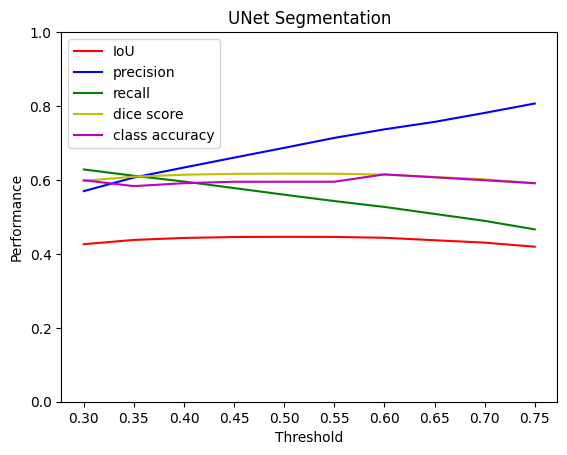

In [31]:
plt.plot(thrs_list, iou_list, 'r', label='IoU')
plt.plot(thrs_list, pre_list, 'b', label='precision')
plt.plot(thrs_list, rec_list, 'g', label='recall')
plt.plot(thrs_list, dice_list, 'y', label='dice score')
if crop == False:
  plt.plot(thrs_list, class_acu_list, 'm', label='class accuracy')
plt.xticks(thrs_list)
if crop == False:
  plt.ylim([0,1]) 
else:
  plt.ylim([0.5,1]) 
plt.title("UNet Segmentation")
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [32]:
# temp = (outputs[0][0]>0.5).float()
# op_ary = temp.to('cpu').detach().numpy()
# gt_ary = labels[0][0].to('cpu').numpy()
# print(op_ary.shape, gt_ary.shape)
# op_ary = op_ary * 255
# gt_ary = gt_ary * 255

In [33]:
# img = Image.fromarray(op_ary)
# img.show()
# img = Image.fromarray(gt_ary)
# img.show()

## 展示預測結果

In [34]:
from google.colab.patches import cv2_imshow
import cv2

# display
d_clean_img, d_img_gt, d_img_pd, d_img_all = [], [], [], []
for i in range(0, len(test_display_index)):
  index = test_display_index[i]
  if i != len(test_display_index) - 1:
    num = test_display_index[i + 1] - test_display_index[i]
  else:
    num = len(test_img) - test_display_index[i]
  
  # 乾淨的原始image
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)
  d_clean_img.append(t)

  # 原始image加上正確的mask
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)

  for n in range(0, num):
    mask = np.where(ground_truths[index + n] > 0.5, True, False)
    if crop == True:
      bbox_dx, bbox_dy = test_bbox[index + n][2] - test_bbox[index + n][0] + 1, test_bbox[index + n][3] - test_bbox[index + n][1] + 1
    else:
      bbox_dx, bbox_dy = 512, 512
    mask = resize_mask(mask, bbox_dx, bbox_dy)
    mask = np.where(mask > 0.5, True, False)

    for y in range(0, mask.shape[0]):
      for x in range(0, mask.shape[1]):
        if mask[y][x] == True:
          if crop == True:
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 255
          else:
            t[y][x][0] = 0
            t[y][x][1] = 0
            t[y][x][2] = 255
  d_img_gt.append(t)

  # 原始image加上預測的bbox
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)

  for n in range(0, num):
    mask = np.where(predictions[index + n] > 0.5, True, False)
    if crop == True:
      bbox_dx, bbox_dy = test_bbox[index + n][2] - test_bbox[index + n][0] + 1, test_bbox[index + n][3] - test_bbox[index + n][1] + 1
    else:
      bbox_dx, bbox_dy = 512, 512
    mask = resize_mask(mask, bbox_dx, bbox_dy)
    mask = np.where(mask > 0.5, True, False)

    for y in range(0, mask.shape[0]):
      for x in range(0, mask.shape[1]):
        if mask[y][x] == True:
          if crop == True:
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 255
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 0
          else:
            t[y][x][0] = 255
            t[y][x][1] = 0
            t[y][x][2] = 0
  d_img_pd.append(t)

  # prediction 和 ground truth 和在一起
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)

  for n in range(0, num):
    gt = np.where(ground_truths[index + n] > 0.5, True, False)
    gt = resize_mask(gt, bbox_dx, bbox_dy)
    gt = np.where(gt > 0.5, True, False)
    pdt = np.where(predictions[index + n] > 0.5, True, False)
    pdt = resize_mask(pdt, bbox_dx, bbox_dy)
    pdt = np.where(pdt > 0.5, True, False)
    if crop == True:
      bbox_dx, bbox_dy = test_bbox[index + n][2] - test_bbox[index + n][0] + 1, test_bbox[index + n][3] - test_bbox[index + n][1] + 1
    else:
      bbox_dx, bbox_dy = 512, 512

    for y in range(0, gt.shape[0]):
      for x in range(0, gt.shape[1]):
        if gt[y][x] == True and pdt[y][x] == True:
          if crop == True:
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 255
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 255
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 255
          else:
            t[y][x][0] = 255
            t[y][x][1] = 255
            t[y][x][2] = 255
        elif gt[y][x] == True:
          if crop == True:
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 255
          else:
            t[y][x][0] = 0
            t[y][x][1] = 0
            t[y][x][2] = 255
        elif pdt[y][x] == True:
          if crop == True:
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 255
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
            t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 0
          else:
            t[y][x][0] = 255
            t[y][x][1] = 0
            t[y][x][2] = 0
  d_img_all.append(t)

In [35]:
for index in range(0, len(d_img_all)):
  print(index)
  cv2_imshow(d_img_all[index])
  if crop == False:
    cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/no_crop/' + str(index) + '.png', d_img_all[index])
  elif padding == False:
    cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/no_pad/' + str(index) + '.png', d_img_all[index])
  else:
    cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/with_pad/' + str(index) + '.png', d_img_all[index])
  cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/origin_image/' + str(index) + '.png', d_clean_img[index])

Output hidden; open in https://colab.research.google.com to view.

## 蛤(?

In [36]:
# import matplotlib.pyplot as plt
# plt.ion()
# with torch.no_grad():
#   for x, _ in dataloaders:
#     y=model(x).sigmoid()
#     img_y=torch.squeeze(y).numpy()
#     plt.imshow(img_y)
#     plt.pause(0.01)
#   plt.show()